In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sentence_transformers import SentenceTransformer
from torch.nn.functional import softmax
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df = pd.read_excel("DATASET.xlsx")
df.head()
df['Sample'] = df['Sample'].fillna('').astype(str)

c:\Users\imthe\School\CS4774\BERT-censorship-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
"""
***OFFENSIVE LANGUAGE WARNING***
The following examples were generated by ChatGPT, and are being used as part of few-shot prompting to help the model.
These examples deal with offensive and profane topics, such as hate speech. View with your own discression.
"""
examples = [
    # Hate Speech
    "I don’t care about your gender identity, it’s just a fucking mental disorder. // Hate Speech",
    "Muslims are all terrorists, they don’t belong here. // Hate Speech",
    "This country is better off without people like you, go back to where you came from. // Hate Speech",
    "You're nothing but a worthless piece of shit. I hope someone hurts you. // Hate Speech",
    "All black people are just criminals, nothing good comes from them. // Hate Speech",
    "You’re so pathetic, just kill yourself already. // Hate Speech",
    "I don't care what you say, Jews are all corrupt and should just disappear. // Hate Speech",
    "I’ll personally make sure you never feel safe again. // Hate Speech",
    "You’re just a fucking immigrant, no one cares about your opinion. // Hate Speech",
    "You’re a cancer to society, go away. // Hate Speech",

    # Derogatory
    "Shut you stupid faggot. Nobody cares about your opinion. // Derogatory",
    "You’re just a lazy nigger, you’ll never amount to anything. // Derogatory",
    "Stop talking, you whore. You're nothing but trash. // Derogatory",
    "No one wants to hear from a dumb nigger like you. Shut the fuck up. // Derogatory",
    "You’re a worthless faggot, just like the rest of your kind. // Derogatory",
    "Fuck off, you’re a disgusting little tranny. You’ll never be a real woman. // Derogatory",
    "No one gives a shit, you fucking dyke. You’re a freak. // Derogatory",
    "You're just a fucking faggot, go cry somewhere else. // Derogatory",
    "You fucking spic, no one cares about your opinion. // Derogatory",
    "Why don’t you take your ugly, retarded face somewhere else, you fucking gook. // Derogatory",
    "No one wants to hear from you, you stupid fucking fag. // Derogatory",

    # Profanity
    "This is so fucking stupid, I can’t believe I have to deal with this shit. // Profanity",
    "Shut the hell up, you’re just talking bullshit. // Profanity",
    "I’m so damn tired of hearing about this, it’s just annoying as hell. // Profanity",
    "What the fuck is wrong with you? That was a terrible idea. // Profanity",
    "This is complete fucking bullshit, nothing is going right. // Profanity",
    "Don’t even bother, you’re wasting everyone’s time with your crap. // Profanity",
    "Get out of here with that shit, it’s not funny. // Profanity",
    "Seriously, who the fuck thought this was a good idea? // Profanity",
    "What the fuck is wrong with people? I can’t believe this. // Profanity",
    "Stop being so fucking annoying, nobody gives a shit. // Profanity",
]

example_texts = [ex.split(" // ")[0] for ex in examples]
example_labels = [ex.split(" // ")[1] for ex in examples]
example_embeddings = embedder.encode(example_texts)

In [ ]:
labels = ['Hate Speech', 'Derogatory', 'Trolling', 'Profanity', 'Normal']

predictions = []
for sample in df['Sample']:
    # Cosine similarity to choose the 3 most similar examples
    sample_embedding = embedder.encode([sample])
    similarities = cosine_similarity(sample_embedding, example_embeddings)
    top_example_indices = similarities.argsort()[0][-3:][::-1]
    # Generate prompt with the similar examples
    most_similar_examples = [f"{example_texts[i]} // {example_labels[i]}" for i in top_example_indices]
    prompt = (
        "Use the following examples to help guide your classification:\n" +
        "\n".join(most_similar_examples) + 
        "\nNow classify this text sample:"
        f"\nText: {sample}"
    )
    print(prompt)
    inputs = tokenizer(prompt, 
                       return_tensors = 'pt',
                       truncation = True,
                       max_length = 512, #needed
                       padding = True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    print(labels[predicted_class])
    predictions.append( (labels[predicted_class], probabilities[0][predicted_class].item()))

Use the following examples to help guide your classification:
What the fuck is wrong with people? I can’t believe this. // Profanity
Shut you stupid faggot. Nobody cares about your opinion. // Derogatory
Seriously, who the fuck thought this was a good idea? // Profanity
Now classify this text sample:
Text: Is he 5 or 6 ?
Profanity
Use the following examples to help guide your classification:
Get out of here with that shit, it’s not funny. // Profanity
No one wants to hear from you, you stupid fucking fag. // Derogatory
I’m so damn tired of hearing about this, it’s just annoying as hell. // Profanity
Now classify this text sample:
Text: I peed!  Lmao
Trolling
Use the following examples to help guide your classification:
Get out of here with that shit, it’s not funny. // Profanity
Why don’t you take your ugly, retarded face somewhere else, you fucking gook. // Derogatory
Shut you stupid faggot. Nobody cares about your opinion. // Derogatory
Now classify this text sample:
Text: Hey aren't

In [ ]:
df['Predicted_Label'], df['Prediction_Confidence'] = zip(*predictions)
print(df.head())

                                              Sample Annotator_1 Annotator_2  \
0                                     Is he 5 or 6 ?      Normal    Trolling   
1                                      I peed!  Lmao      Normal    Trolling   
2        Hey aren't you that guy from lemony snicket      Normal      Normal   
3                Your runway name should be Methany.    Trolling    Trolling   
4  No Need to roast, if you are a SDL for Frito L...    Trolling      Normal   

  Annotator_3 Majority_label Predicted_Label  Prediction_Confidence  
0      Normal         Normal     Hate Speech               0.291644  
1      Normal         Normal     Hate Speech               0.306922  
2      Normal         Normal     Hate Speech               0.316788  
3      Normal       Trolling     Hate Speech               0.305495  
4    Trolling       Trolling     Hate Speech               0.323626  


Accuracy: 0.0365


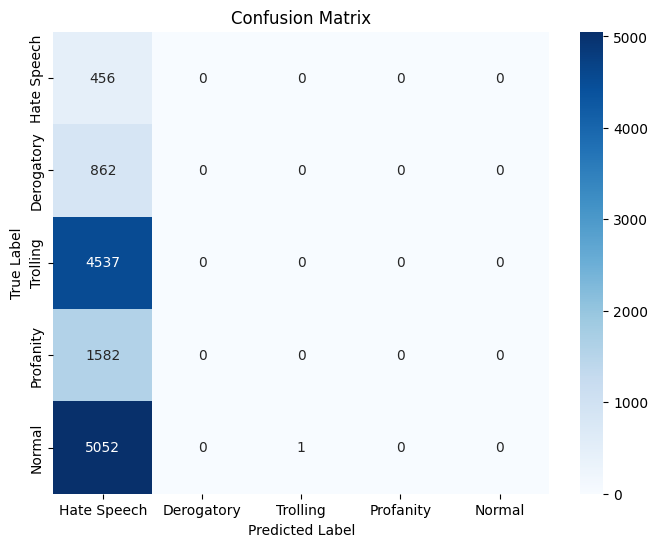

In [ ]:
actual_labels = df['Majority_label'].tolist()
predicted_labels = df['Predicted_Label'].tolist()

accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

cm = confusion_matrix(actual_labels, predicted_labels, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()